In [1]:
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pyemma
import deeptime as dt
import mdtraj as md
import networkx as nx
from timescales import implied_timescales_msm
from copy import deepcopy
import nglview as nv
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cosine
from pathlib import Path
from sklearn.preprocessing import RobustScaler
import mdshare
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
def FES_plot(x, y, ax, cbar=False, cax=None, levels=15, nbins=60, weights=None): pyemma.plots.plot_free_energy(x, y, levels=levels, nbins=nbins, ax=ax, cbar=cbar, cax=cax, weights=weights)

In [4]:
fake_trj_fname = [str(p) for p in Path('ADP_cg2aa_hallucinate/').glob('aa_hallucinate_*')]
fake_top_fname = 'ADP_testset/AA.pdb'

# REAL

In [5]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='ref_ADP_data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='ref_ADP_data')
num_timescales=16
lagtime = 5

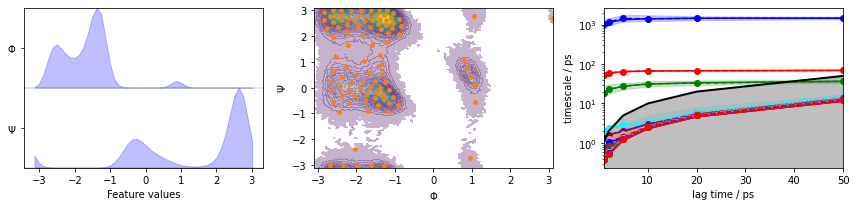

In [6]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

cluster = dt.clustering.KMeans(100, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


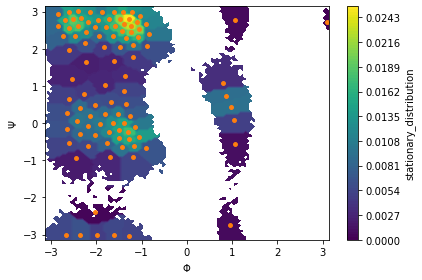

In [7]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[np.concatenate(dtrajs)],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999999889, max=1.0000000000002007)


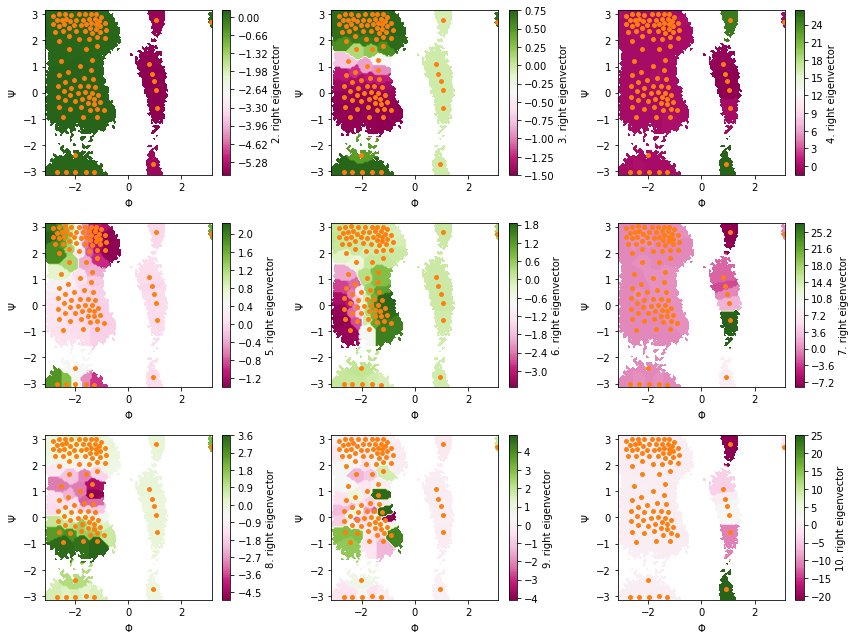

In [8]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[np.concatenate(dtrajs), i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

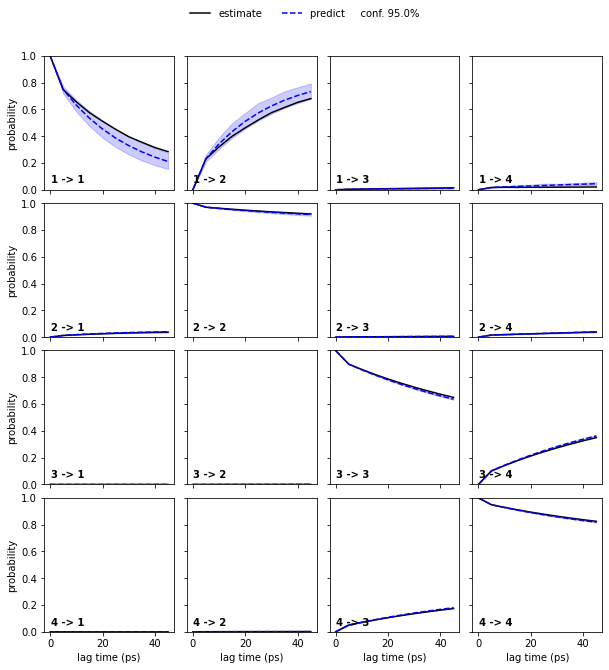

In [9]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [10]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
real_sample_mean = sample_mean
real_sample_conf_l = sample_conf_l
real_sample_conf_r = sample_conf_r

Mean of ITS #0: 1445.325860
Confidence interval of ITS #0: [1199.777699, 1743.913904]
Mean of ITS #1: 64.451404
Confidence interval of ITS #1: [63.663301, 65.163589]
Mean of ITS #2: 27.398749
Confidence interval of ITS #2: [21.656375, 32.872914]
Mean of ITS #3: 2.799286
Confidence interval of ITS #3: [2.775200, 2.827199]
Mean of ITS #4: 1.982570
Confidence interval of ITS #4: [1.936347, 2.035061]
Mean of ITS #5: 1.720688
Confidence interval of ITS #5: [1.544060, 1.970393]
Mean of ITS #6: 1.526863
Confidence interval of ITS #6: [1.454070, 1.796407]
Mean of ITS #7: 1.419390
Confidence interval of ITS #7: [1.317119, 1.517314]
Mean of ITS #8: 1.337302
Confidence interval of ITS #8: [1.306469, 1.422587]
Mean of ITS #9: 1.313769
Confidence interval of ITS #9: [1.291818, 1.351840]
Mean of ITS #10: 1.300360
Confidence interval of ITS #10: [1.280778, 1.323239]
Mean of ITS #11: 1.290489
Confidence interval of ITS #11: [1.270558, 1.310446]
Mean of ITS #12: 1.281130
Confidence interval of ITS #12:

In [11]:
evec_real = eigvec
dtrajs_real = dtrajs
projected_data_real = projected_data

In [12]:
real_trj = md.load(files, top=pdb).center_coordinates()

In [13]:
_, phi = md.compute_phi(real_trj, periodic=False)
phi = phi.flatten()
_, psi = md.compute_psi(real_trj, periodic=False)
psi = psi.flatten()

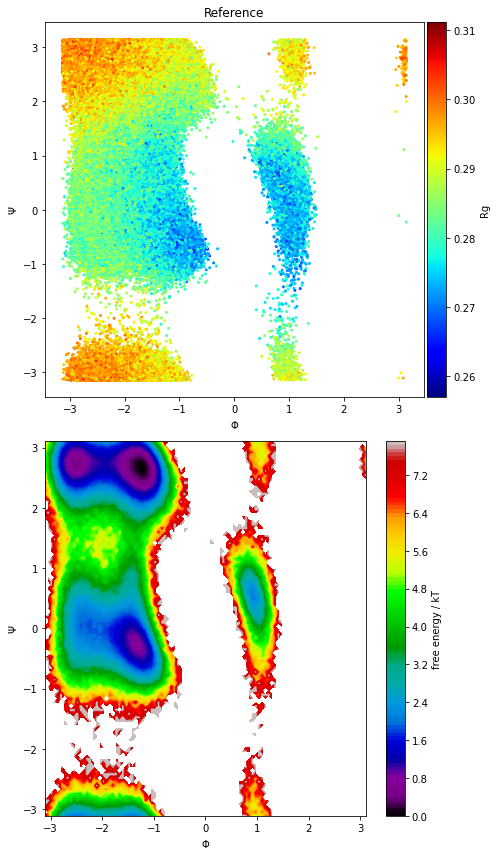

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(7, 12))
s=4
cmap='jet'
im = ax[0].scatter(phi, psi, c=md.compute_rg(real_trj), s=s, cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='Rg')

ax[0].set_xlabel('$\Phi$')
ax[0].set_ylabel('$\Psi$')
ax[0].set_title('Reference')


FES_plot(phi, psi, ax[1], cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax[1].set_xlabel('$\Phi$')
ax[1].set_ylabel('$\Psi$')

plt.tight_layout()
plt.show()

# Fake

In [15]:
pdb = fake_top_fname
files = fake_trj_fname

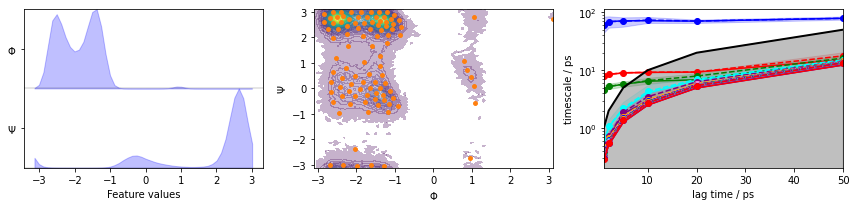

In [16]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

#cluster = dt.clustering.KMeans(100, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


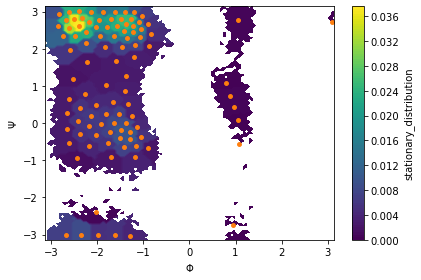

In [17]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[np.concatenate(dtrajs)],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999999917, max=1.0000000000000024)


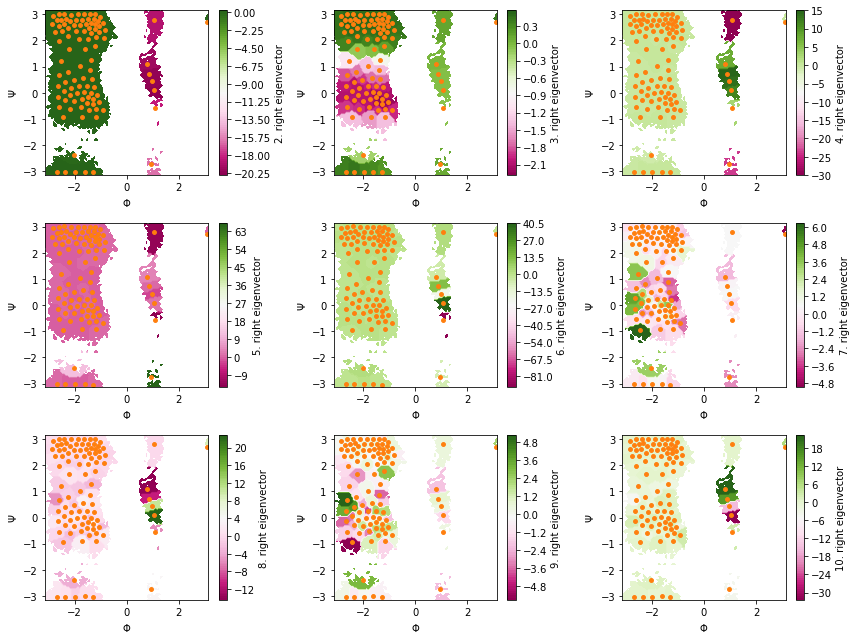

In [18]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[np.concatenate(dtrajs), i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

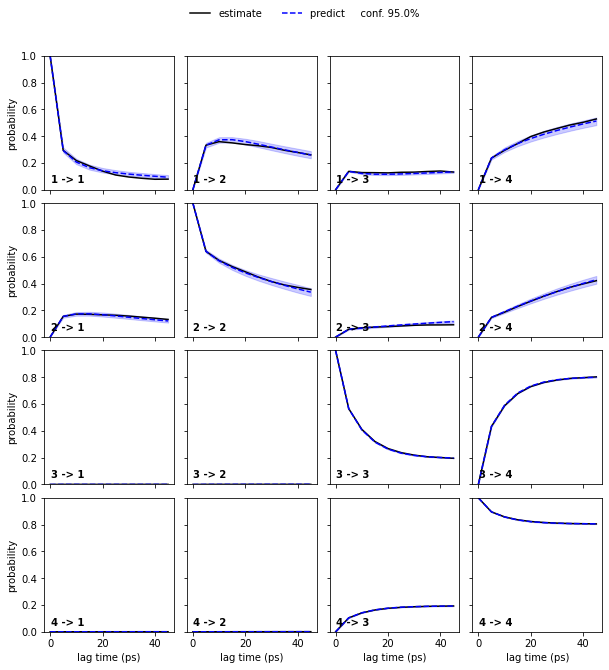

In [19]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [20]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
fake_sample_mean = sample_mean
fake_sample_conf_l = sample_conf_l
fake_sample_conf_r = sample_conf_r

Mean of ITS #0: 70.607108
Confidence interval of ITS #0: [58.846118, 81.489502]
Mean of ITS #1: 9.016242
Confidence interval of ITS #1: [8.914832, 9.157328]
Mean of ITS #2: 5.674561
Confidence interval of ITS #2: [5.135616, 6.389814]
Mean of ITS #3: 2.219494
Confidence interval of ITS #3: [1.838082, 3.067698]
Mean of ITS #4: 1.873039
Confidence interval of ITS #4: [1.584733, 2.098649]
Mean of ITS #5: 1.579754
Confidence interval of ITS #5: [1.483145, 1.806879]
Mean of ITS #6: 1.505521
Confidence interval of ITS #6: [1.468788, 1.606898]
Mean of ITS #7: 1.479891
Confidence interval of ITS #7: [1.448285, 1.520964]
Mean of ITS #8: 1.461835
Confidence interval of ITS #8: [1.436244, 1.509244]
Mean of ITS #9: 1.447867
Confidence interval of ITS #9: [1.422894, 1.483819]
Mean of ITS #10: 1.434300
Confidence interval of ITS #10: [1.412579, 1.460208]
Mean of ITS #11: 1.422870
Confidence interval of ITS #11: [1.401150, 1.450226]
Mean of ITS #12: 1.412101
Confidence interval of ITS #12: [1.393552, 

In [21]:
evec_fake = eigvec
dtrajs_fake = dtrajs
projected_data_fake = projected_data

In [22]:
fake_trj = md.load(fake_trj_fname, top=fake_top_fname).center_coordinates()

In [23]:
_, phi = md.compute_phi(fake_trj, periodic=False)
phi = phi.flatten()
_, psi = md.compute_psi(fake_trj, periodic=False)
psi = psi.flatten()

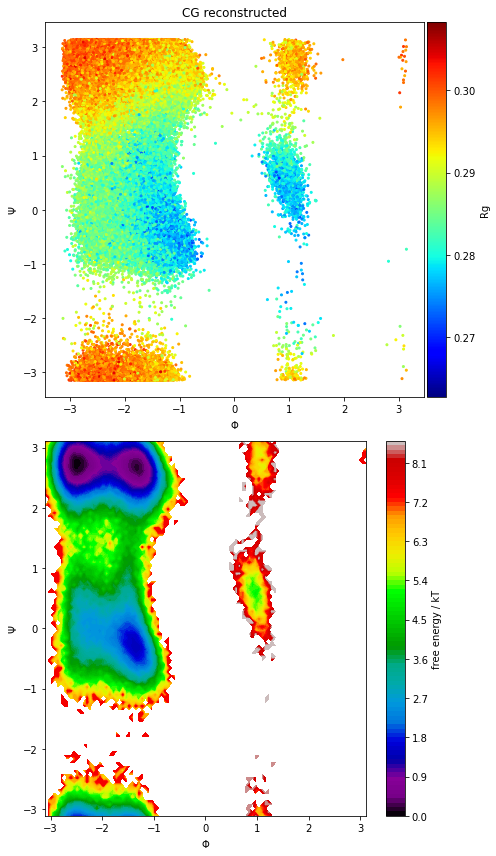

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(7, 12))
s=4
cmap='jet'
im = ax[0].scatter(phi, psi, c=md.compute_rg(fake_trj), s=s, cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='Rg')

ax[0].set_xlabel('$\Phi$')
ax[0].set_ylabel('$\Psi$')
ax[0].set_title('CG reconstructed')


FES_plot(phi, psi, ax[1], cbar=True, levels=100, nbins=100, weights=np.concatenate(msm.compute_trajectory_weights(dtrajs)))
ax[1].set_xlabel('$\Phi$')
ax[1].set_ylabel('$\Psi$')

plt.tight_layout()
plt.show()

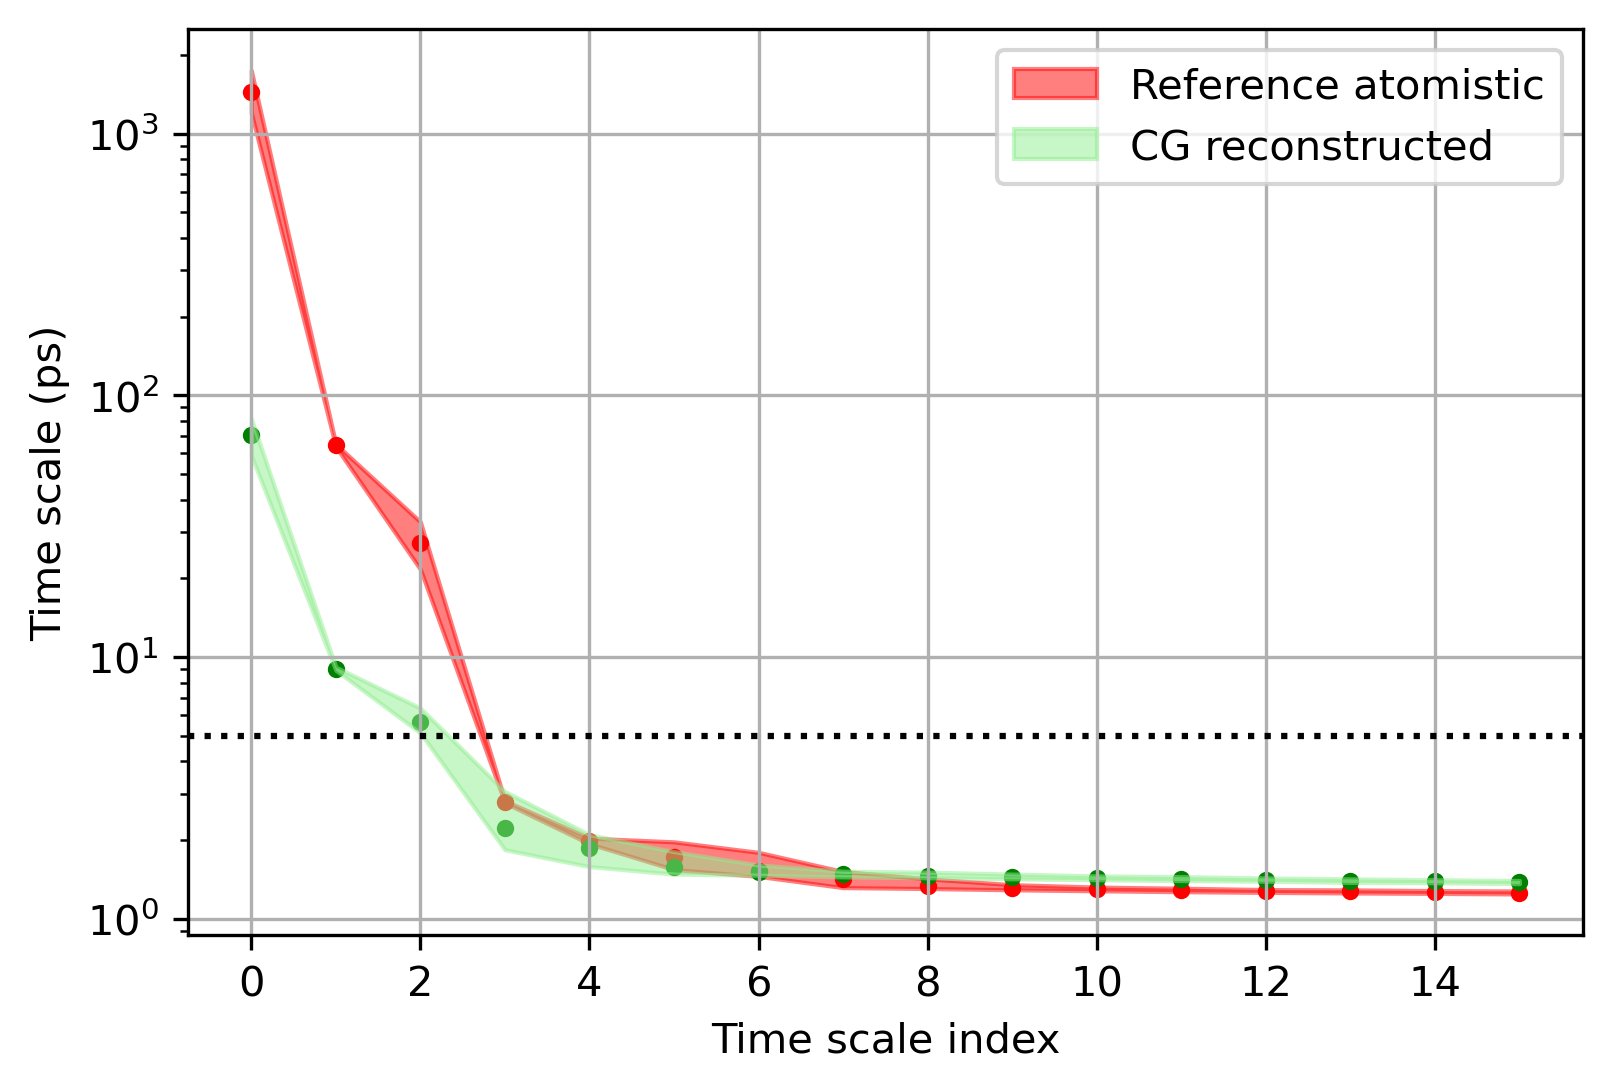

In [25]:
plt.figure(dpi=300)
plt.grid()

m = real_sample_mean
r =  real_sample_conf_r
l =  real_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='r')
plt.scatter(x, y, s=10, color='r')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='red', label='Reference atomistic')
plt.yscale('log')

m = fake_sample_mean
r =  fake_sample_conf_r
l =  fake_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='g')
plt.scatter(x, y, s=10, color='g')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='lightgreen', label='CG reconstructed')
plt.yscale('log')

plt.axhline(lagtime, linestyle=':', c='k')
plt.legend()
plt.xlabel('Time scale index')
plt.ylabel('Time scale (ps)')
plt.show()

In [26]:
evec_fake = eigvec
dtrajs_fake = dtrajs
projected_data_fake = projected_data

In [27]:
scores = list()
for ts in tqdm(range(1, num_timescales+1)):
    ev = evec_real[np.concatenate(dtrajs_real), ts][..., None]
    X = np.concatenate((np.concatenate(projected_data_real), ev), axis=-1)

    x = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
    y = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)

    ret_real = binned_statistic_2d(X[:, 0], X[:, 1], X[:, 2], statistic=np.mean, bins=[x, y])
    
    ev = evec_fake[np.concatenate(dtrajs_fake), ts][..., None]
    X = np.concatenate((np.concatenate(projected_data_fake), ev), axis=-1)

    ret_fake = binned_statistic_2d(X[:, 0], X[:, 1], X[:, 2], statistic=np.mean, bins=[x, y])
    
    mask_real = ~np.isnan(ret_real.statistic.flatten())
    mask_fake = ~np.isnan(ret_fake.statistic.flatten())
    mask = np.logical_and(mask_real, mask_fake)
    
    scores.append(abs(1 - cosine(ret_real.statistic.flatten()[mask], ret_fake.statistic.flatten()[mask])))

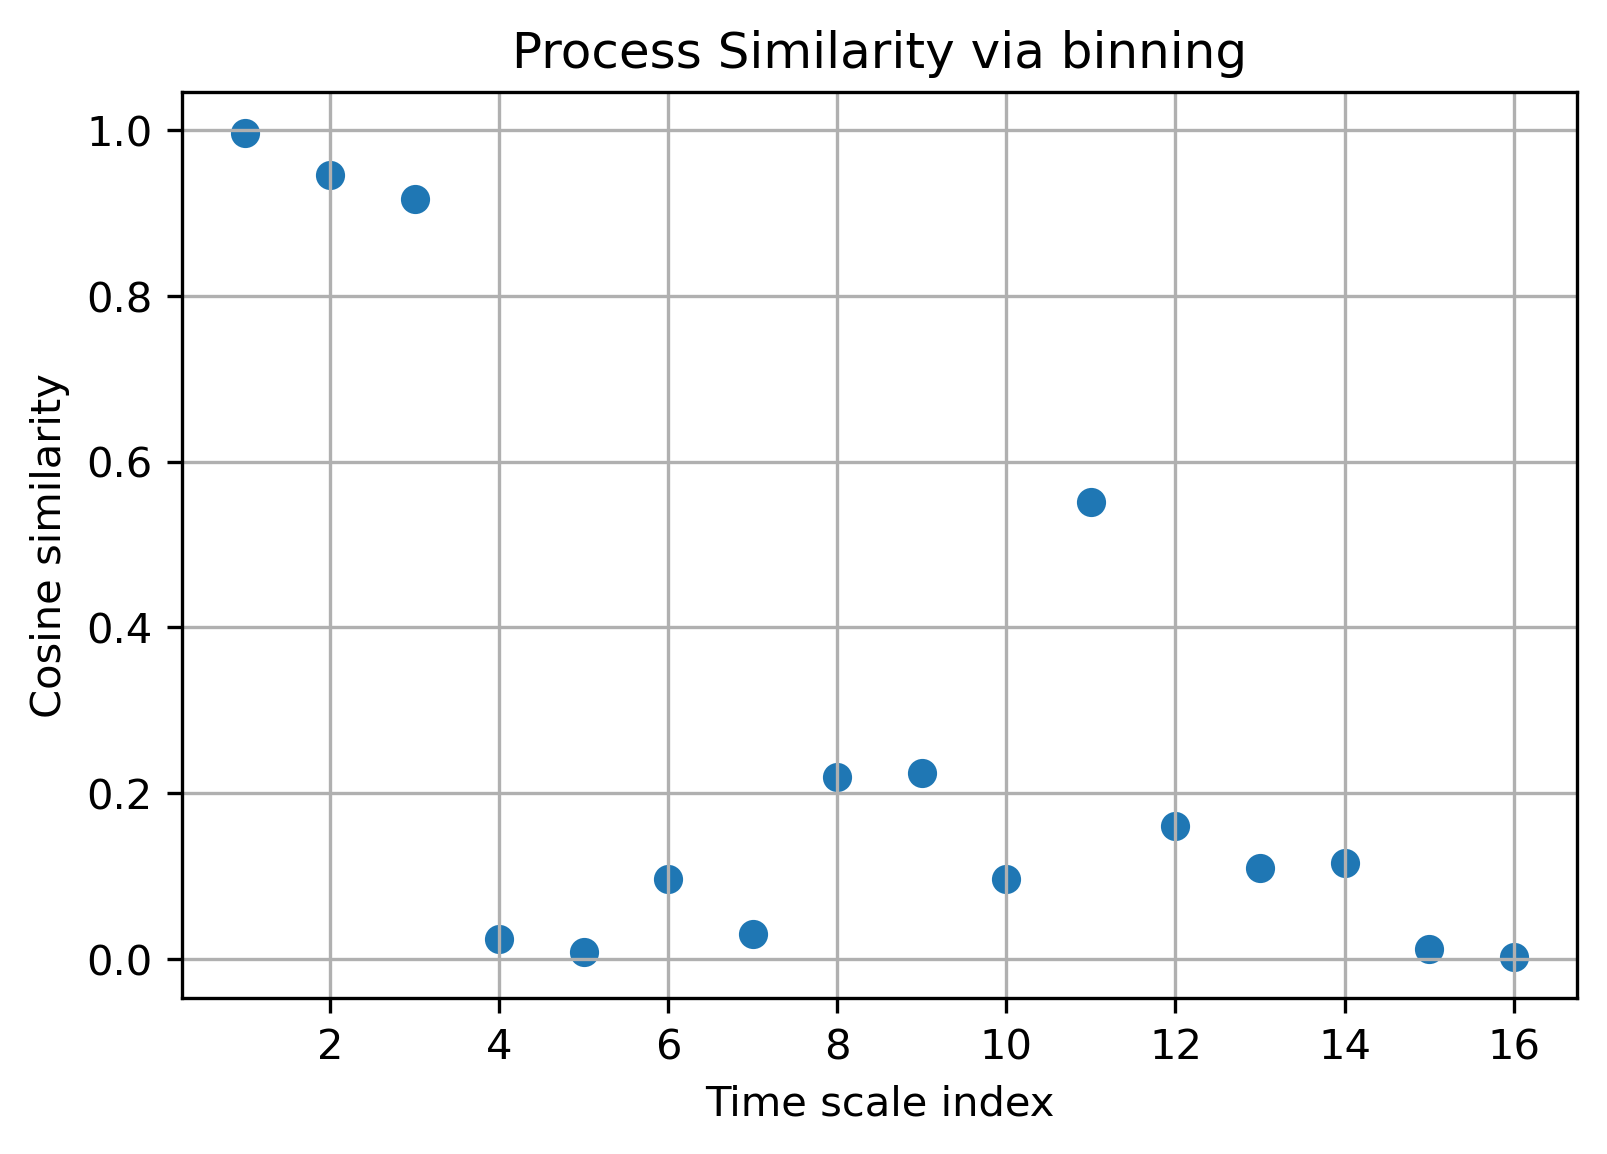

In [28]:
plt.figure(dpi=300)
plt.scatter(range(1, len(scores) + 1), scores)
plt.grid()
plt.xlabel('Time scale index')
plt.ylabel('Cosine similarity')
plt.title('Process Similarity via binning')
plt.show()

In [29]:
scores = list()
for ts in tqdm(range(1, num_timescales+1)):
    scores.append(abs(1 - cosine(evec_real[:, ts], evec_fake[:, ts])))    

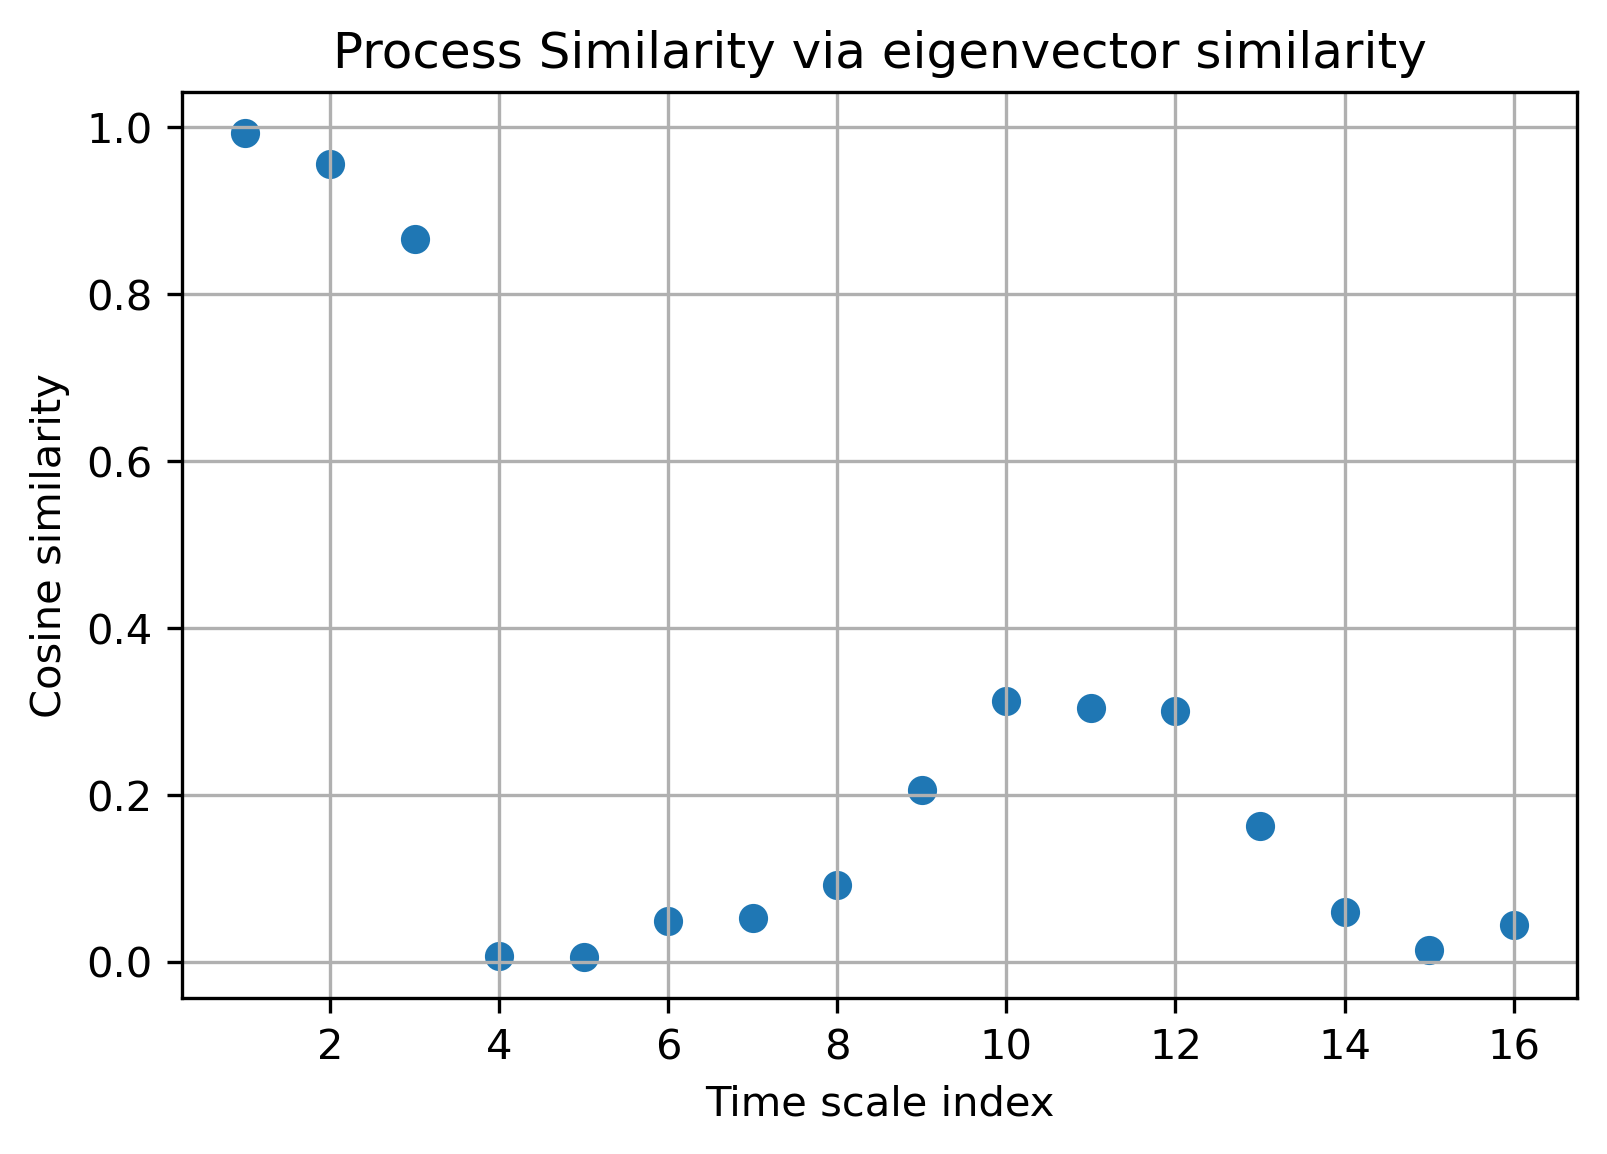

In [30]:
plt.figure(dpi=300)
plt.scatter(range(1, len(scores) + 1), scores)
plt.grid()
plt.xlabel('Time scale index')
plt.ylabel('Cosine similarity')
plt.title('Process Similarity via eigenvector similarity')
plt.show()